## Introduction

Dataset: [NYSE](https://www.kaggle.com/datasets/dgawlik/nyse/data)

### Stock (Closing) Price Prediction

Why: money

We begin with some time series analysis: seasonal decomposition and stationarity testing.
Next, we employ smoothing techniques to approximate the time series: rolling mean and exponential smoothing (from simple to holt winter's).
Then, we discuss model evaluation: scoring and cross validation.
Finally, we'll use ARIMA, RNNs and RandomForest to forecast the closing price of stock (AAPL).

Libraries:
* numpy, pandas, matplotlib for data manipulation and visualization
* [sklearn](https://scikit-learn.org/stable/index.html) for preprocessors and scoring
* [statsmodels](https://www.statsmodels.org/stable/index.html) for analysis and model (ARIMA)
* [keras](https://keras.io/guides/working_with_rnns/) for RNN

In [1]:
import pandas as pd

prices = pd.read_csv("prices-split-adjusted.csv")

## Time Series Analysis

In [2]:
stock_symbol = "AAPL"

In [3]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    851264 non-null  object 
 1   symbol  851264 non-null  object 
 2   open    851264 non-null  float64
 3   close   851264 non-null  float64
 4   low     851264 non-null  float64
 5   high    851264 non-null  float64
 6   volume  851264 non-null  float64
dtypes: float64(5), object(2)
memory usage: 45.5+ MB


In [4]:
prices.set_index("date", inplace=True)
prices.sort_index(inplace=True)

In [5]:
X = prices[prices.symbol == stock_symbol].drop(["symbol"], axis=1)

In [6]:
X.describe()

,open,close,low,high,volume
count,1762.000000,1762.000000,1762.000000,1762.000000,1.762000e+03
mean,79.427744,79.402683,78.640034,80.140447,9.422578e+07
std,28.339001,28.330794,28.108525,28.561027,6.020519e+07
min,27.481428,27.435715,27.178572,28.000000,1.147590e+07
25%,55.401787,55.450000,54.672501,55.909286,4.917478e+07
50%,78.742146,78.435711,77.631428,79.344284,8.050385e+07
75%,102.979998,103.092503,102.500000,104.424997,1.210816e+08
max,134.460007,133.000000,131.399994,134.539993,4.702495e+08


In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot(list_of_series,
         legends=["actual", "predicted"],
         title="Price: actual vs predicted"):
    for i, series in enumerate(list_of_series):
        ax = series.plot(figsize=(16, 8))
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.legend(legends)
    plt.title(title)
    plt.show()

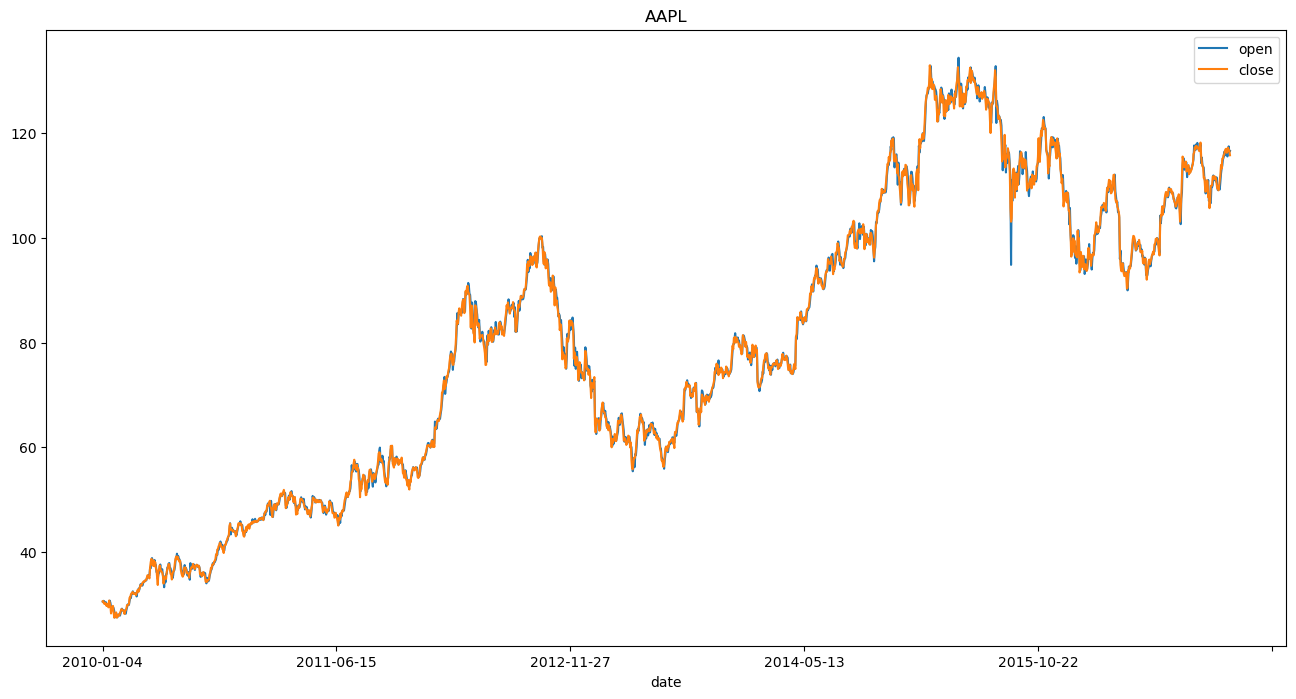

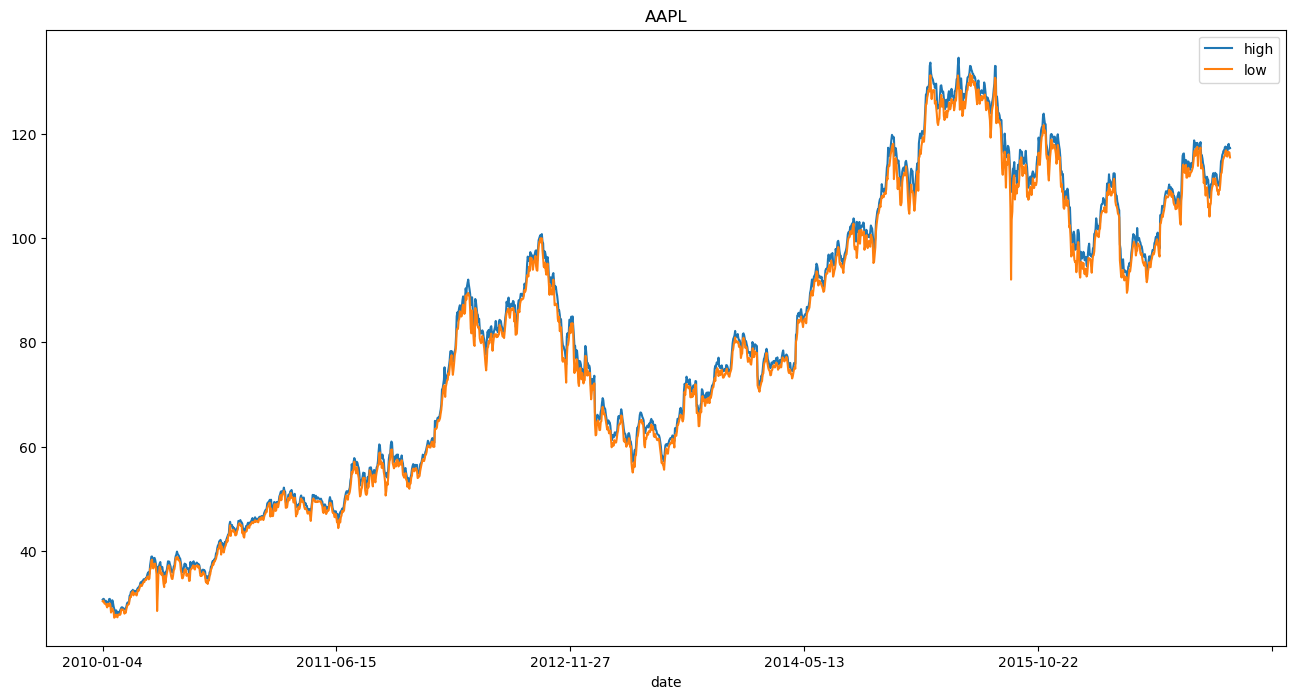

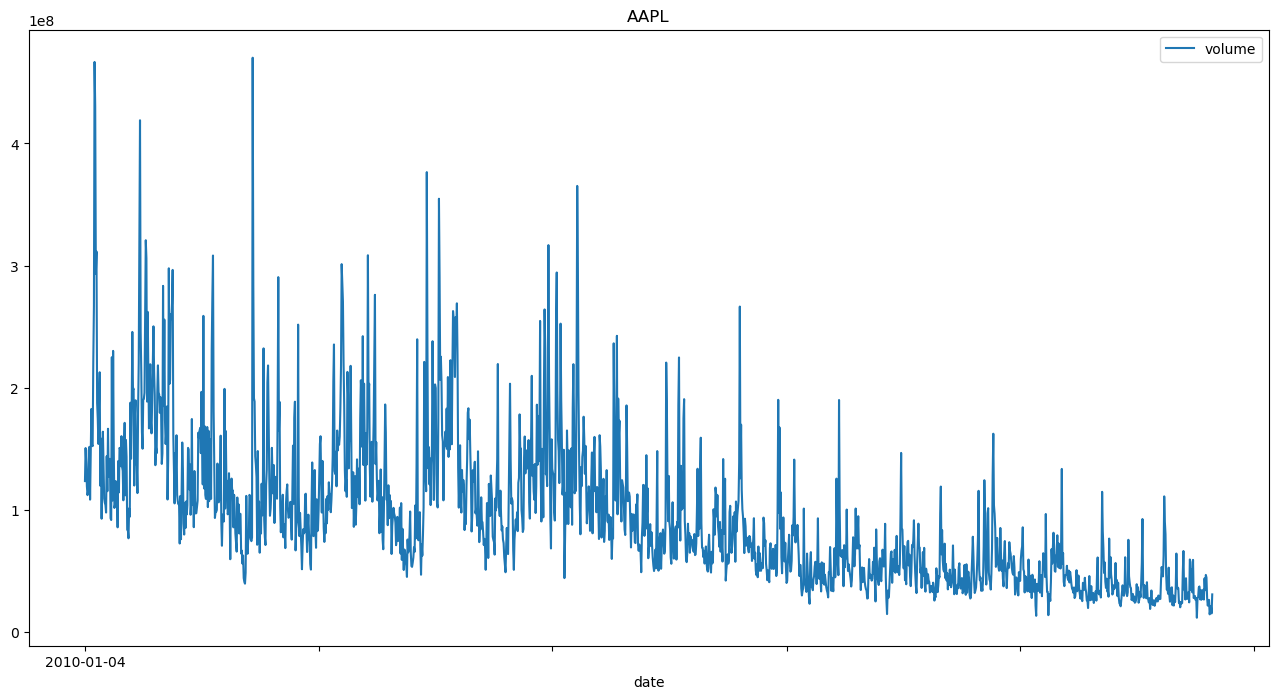

In [8]:
plot([X.open, X.close], ["open", "close"], title=stock_symbol)
plot([X.high, X.low], ["high", "low"], title=stock_symbol)
plot([X.volume], ["volume"], title=stock_symbol)

Not much to note except an upward trend of the price and downward trend of the volume.

### Seasonal decomposition

See [Decomposition of time series](https://en.wikipedia.org/wiki/Decomposition_of_time_series). First, let's see if there _is_ any seasonality. Seasonality is variations that occur at regular intervals such as weekly, monthly, quarterly etc.

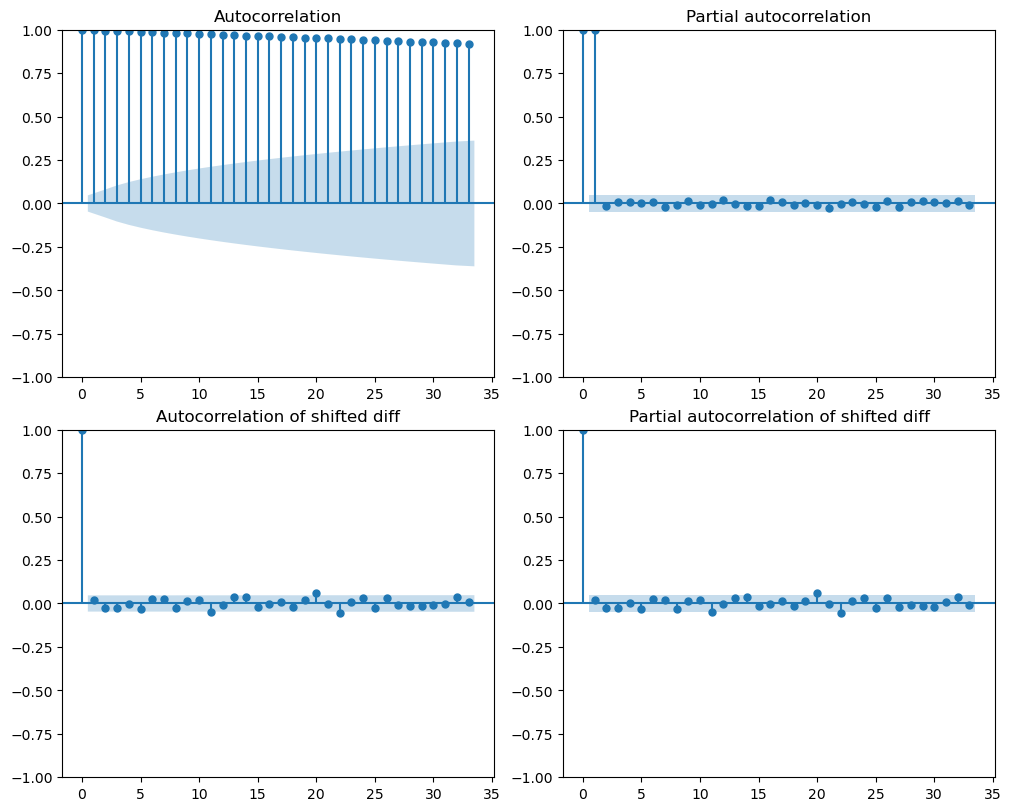

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(10, 8),
    constrained_layout=True,
)
ax = plot_acf(X.close, title="Autocorrelation", ax=axes[0, 0])
ax = plot_pacf(X.close, title="Partial autocorrelation", ax=axes[0, 1])
ax = plot_acf(X.close.diff().dropna(), title="Autocorrelation of shifted diff", ax=axes[1, 0])
ax = plot_pacf(X.close.diff().dropna(), title="Partial autocorrelation of shifted diff", ax=axes[1, 1])

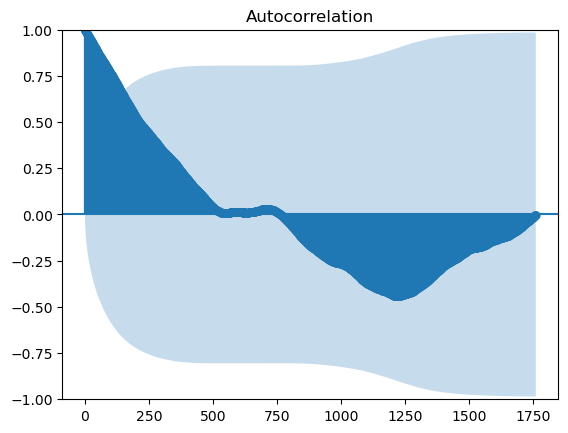

In [10]:
ax = plot_acf(X.close, lags=len(X) - 1)

There does not seem to be any seasonality. The [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation_function) and [partial autocorrelation](https://en.wikipedia.org/wiki/Partial_autocorrelation_function) plots will come handy with forecasting (ARIMA).

We can still decompose into trends and residue. If we had to guess the seasonal period, it would either be quarterly or yearly (financial reports).

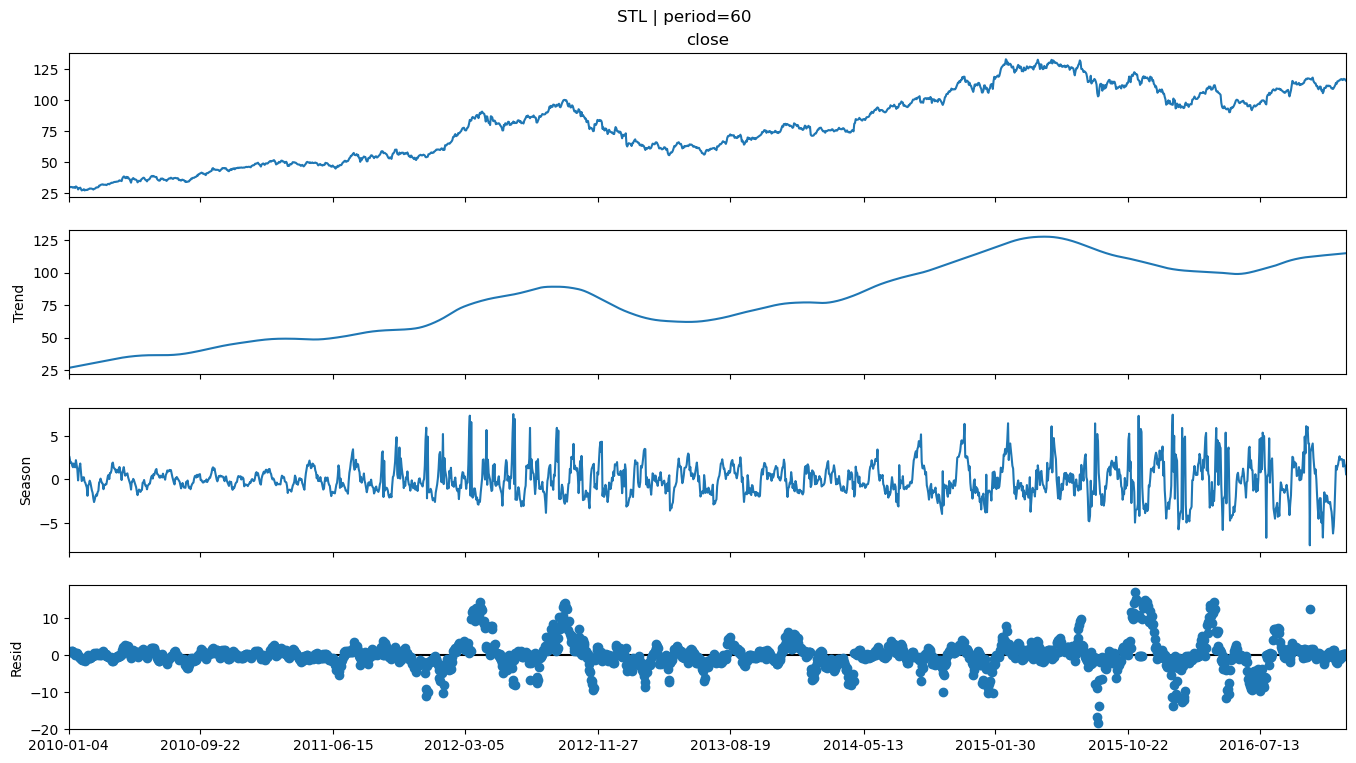

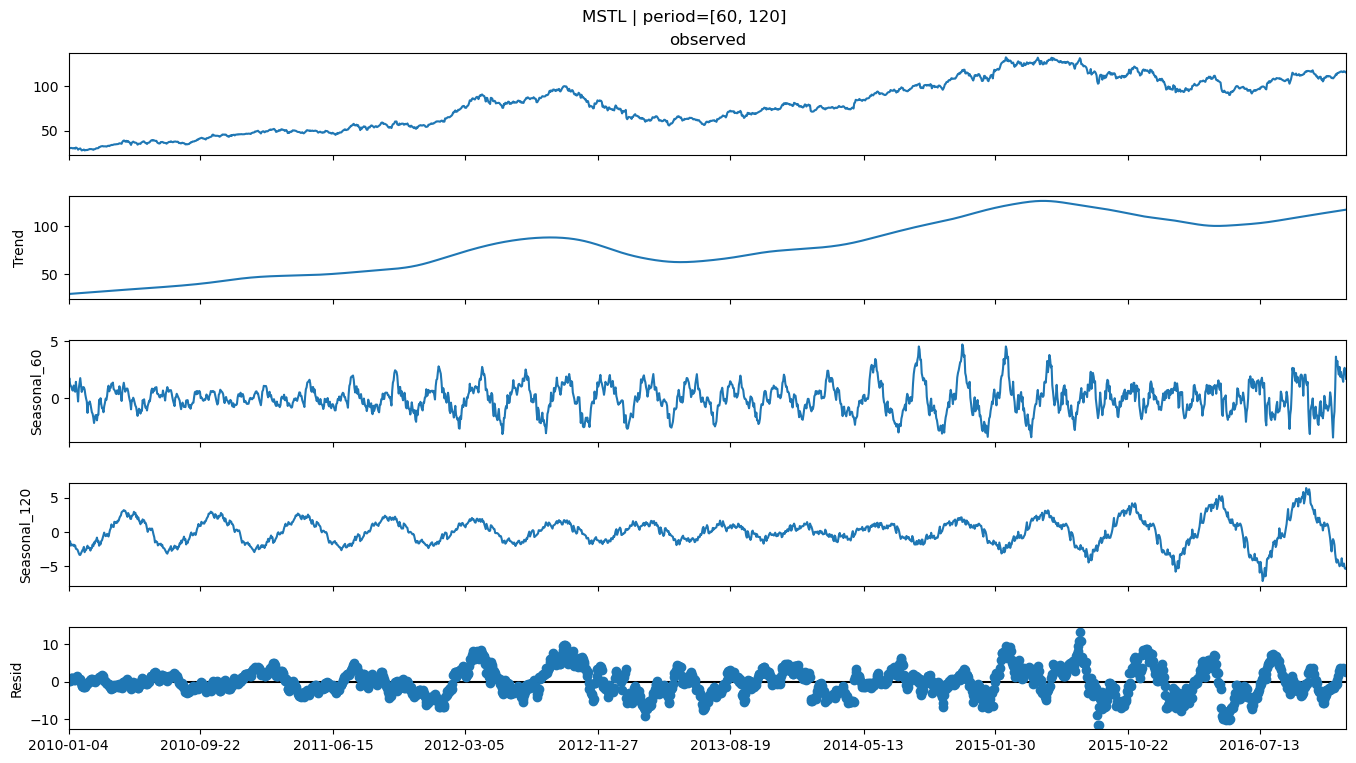

In [11]:
from statsmodels.tsa.seasonal import STL, MSTL

def plot_decomposition(decomposition, title):
    fig = decomposition.plot()
    fig.suptitle(title)
    fig.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    fig.set_size_inches(16, 8)
    
# x = trend + seasonal + residual
# Season-Trend decomposition using LOESS.
plot_decomposition(STL(X.close, period=60, robust=True).fit(), "STL | period=60")

# Multiple STL
plot_decomposition(MSTL(X.close, periods=[60, 120]).fit(), "MSTL | period=[60, 120]")

The upward trends are much clearer. Lack of seasonality is also evident from the erratic residual.

### [Stationarity](https://en.wikipedia.org/wiki/Stationary_process)

Stationarity simply means that the mean and the variance is independent of time. Why do we care? It's easier to analyze, and many algorithms assume so.

In [12]:
from statsmodels.tsa.stattools import adfuller

def is_stationary(series, quiet=False):
    adf, p_value, num_lags_used, num_observations = adfuller(series)[:4]
    if not quiet:
        print(f"adf={adf}\n"
              f"pvalue={p_value}\n"
              f"num_lags_used={num_lags_used}\n"
              f"num_observations={num_observations}\n")
    return p_value < 0.05

In [13]:
is_stationary(X.close)

adf=-1.324457792009011
pvalue=0.6179099002369274
num_lags_used=0
num_observations=1761



False

Not stationary. Now let's try shifted series.

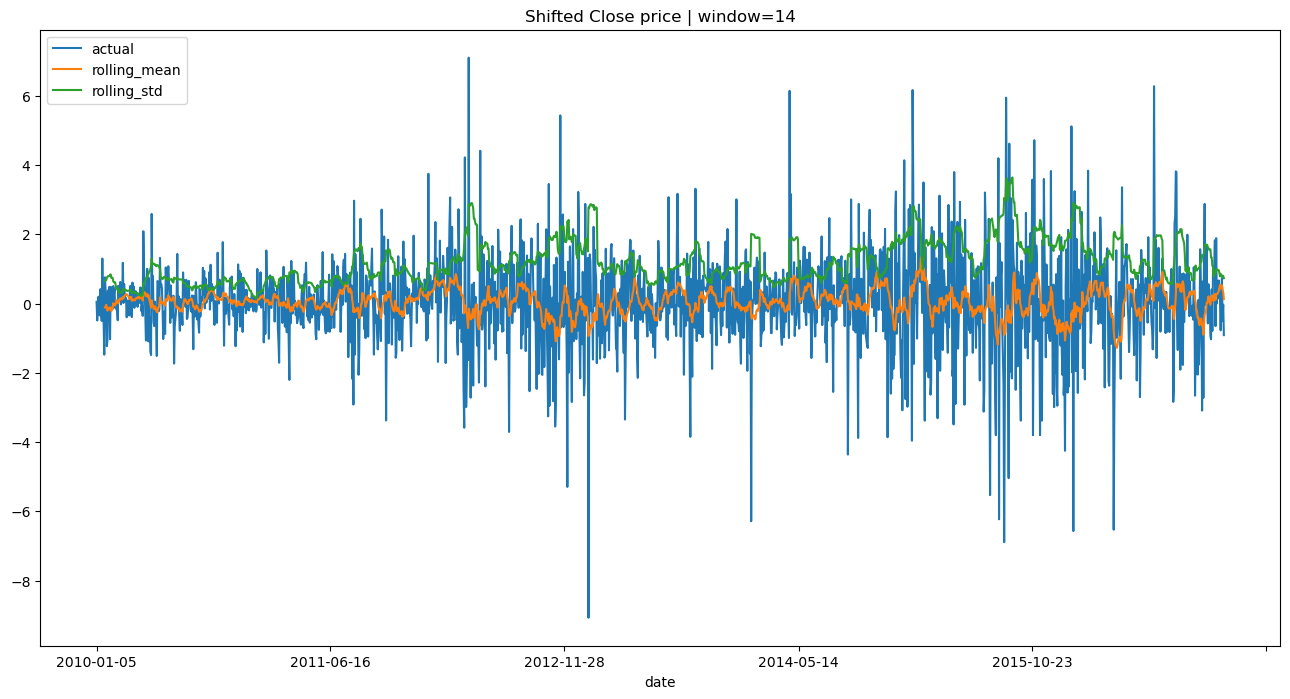

adf=-41.12215849745493
pvalue=0.0
num_lags_used=0
num_observations=1760



True

In [14]:
shifted_X_close = X.close.diff().dropna()

plot([shifted_X_close,
      shifted_X_close.rolling(window=14).mean(),
      shifted_X_close.rolling(window=14).std()],
     ["actual", "rolling_mean", "rolling_std"],
     "Shifted Close price | window=14")
is_stationary(shifted_X_close)

Ok, stationary. Differencing is one of the ways to make a series stationary as we just saw.

In [15]:
def make_stationary(X):
    stationary = np.all([
        is_stationary(X[col], quiet=True)
        for col in X.columns
    ])
    if not stationary:
        X_diff = X.diff().dropna()
        assert np.all([is_stationary(X_diff[col], quiet=True) for col in X.columns])
    return X_diff if not stationary else X

### Approximation: [Smoothing](https://en.wikipedia.org/wiki/Smoothing)

Approximation/smoothing removes noise to better capture important patterns. There are [many](https://en.wikipedia.org/wiki/Smoothing#Algorithms) different methods. We try out Rolling Mean and Exponential Smoothing here.

#### [Rolling Mean](https://en.wikipedia.org/wiki/Moving_average)

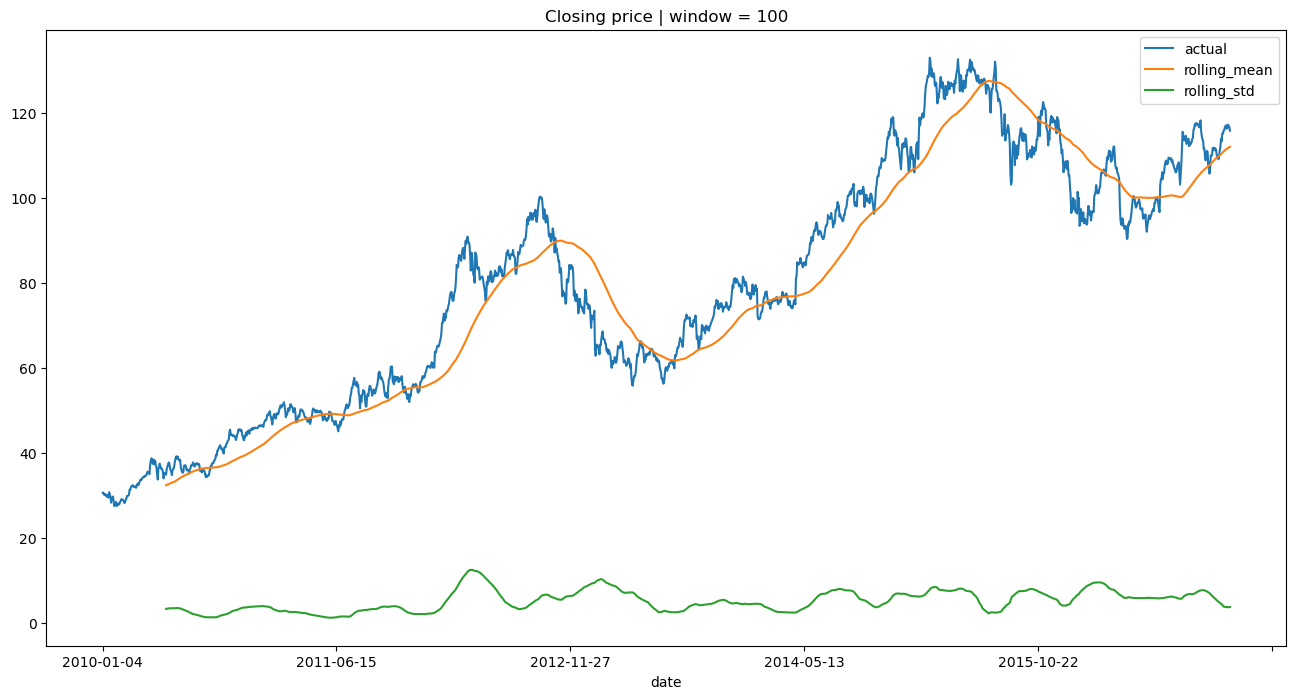

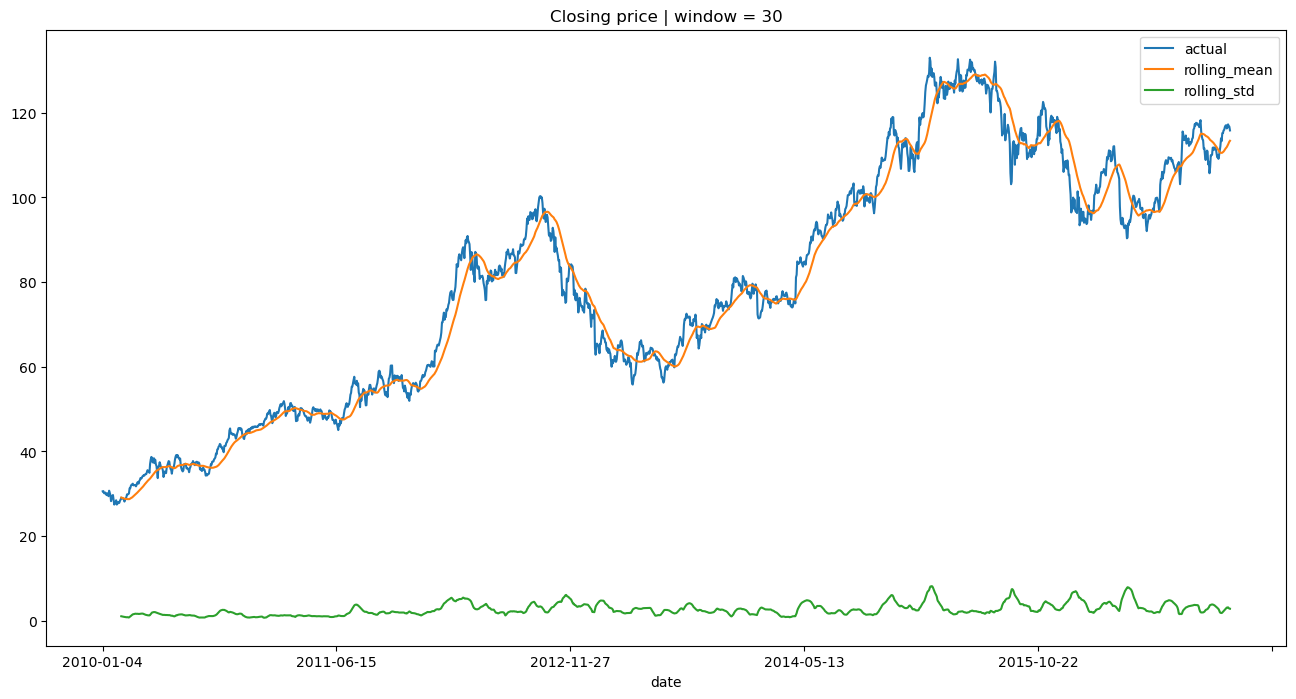

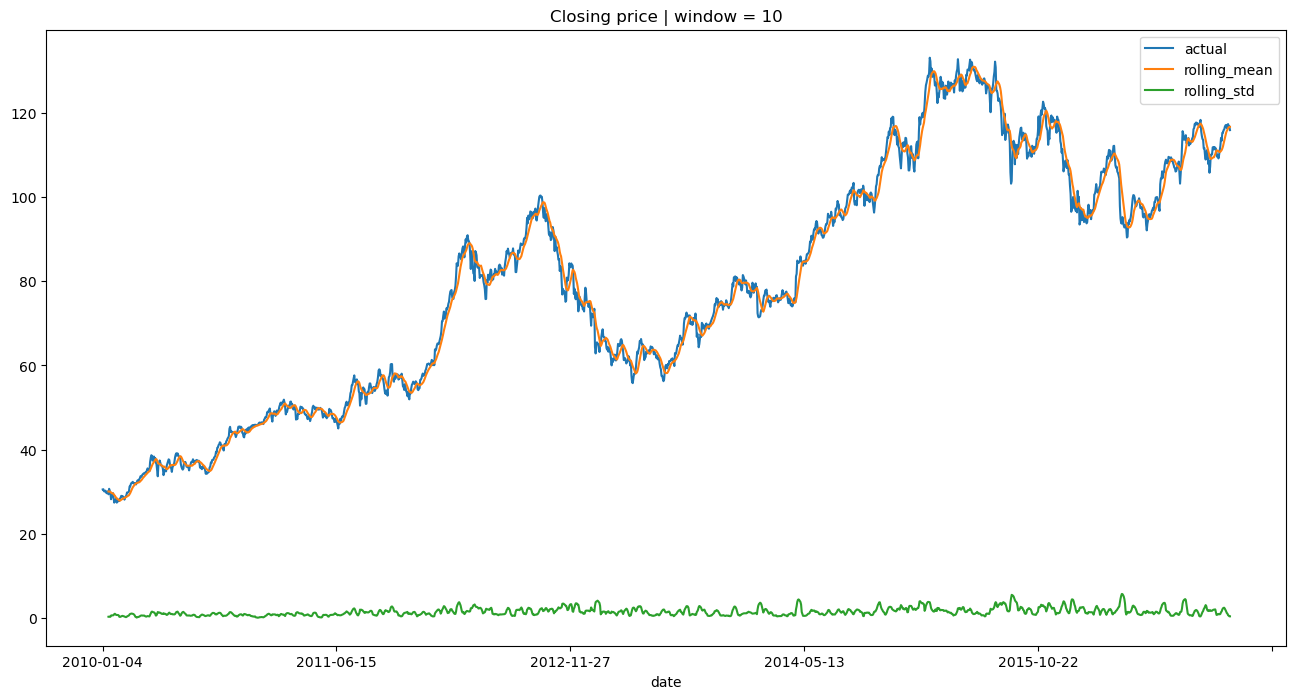

In [16]:
for window in [100, 30, 10]:
    plot([X.close,
          X.close.rolling(window=window).mean(),
          X.close.rolling(window=window).std(),
         ],
         ["actual", "rolling_mean", "rolling_std"],
         f"Closing price | window = {window}")

Smaller the window, more accurate the approximation.

#### [Exponential Smoothing](https://en.wikipedia.org/wiki/Exponential_smoothing)

A bit more complex than a simple moving average. Checkout this [statsmodels notebook](https://www.statsmodels.org/stable/examples/notebooks/generated/exponential_smoothing.html) for an overview.

In [17]:
import warnings
warnings.filterwarnings("ignore")

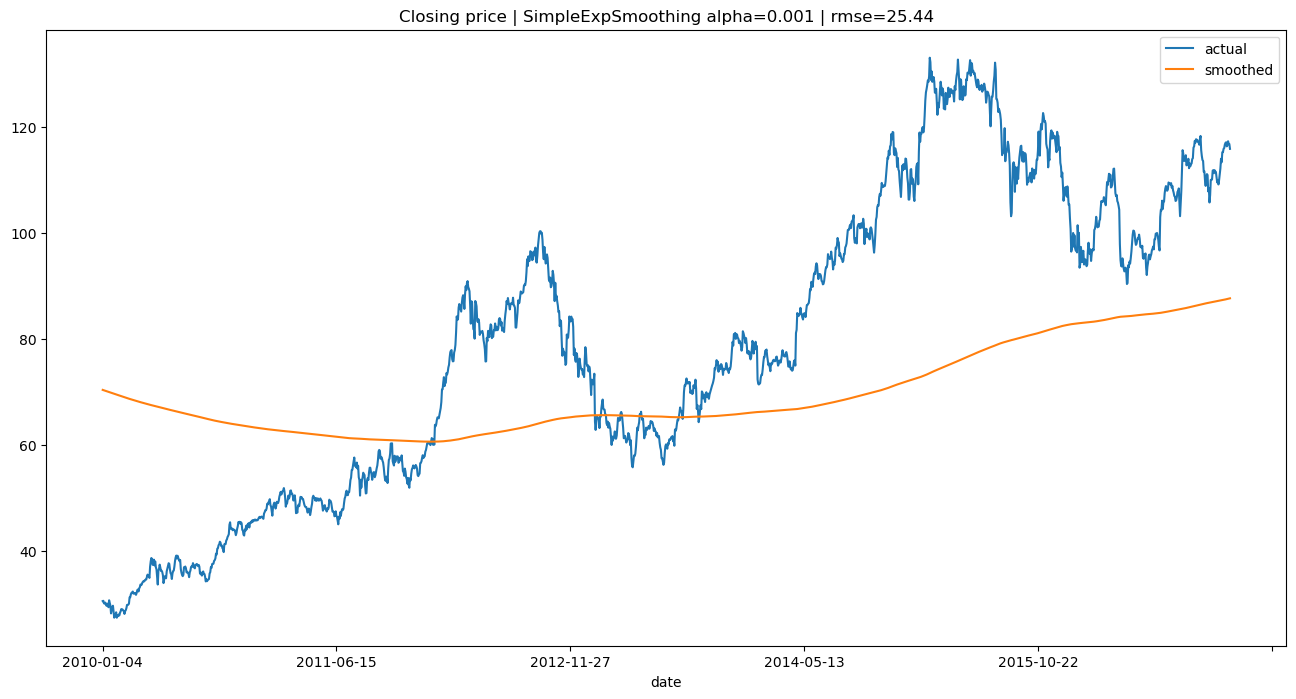

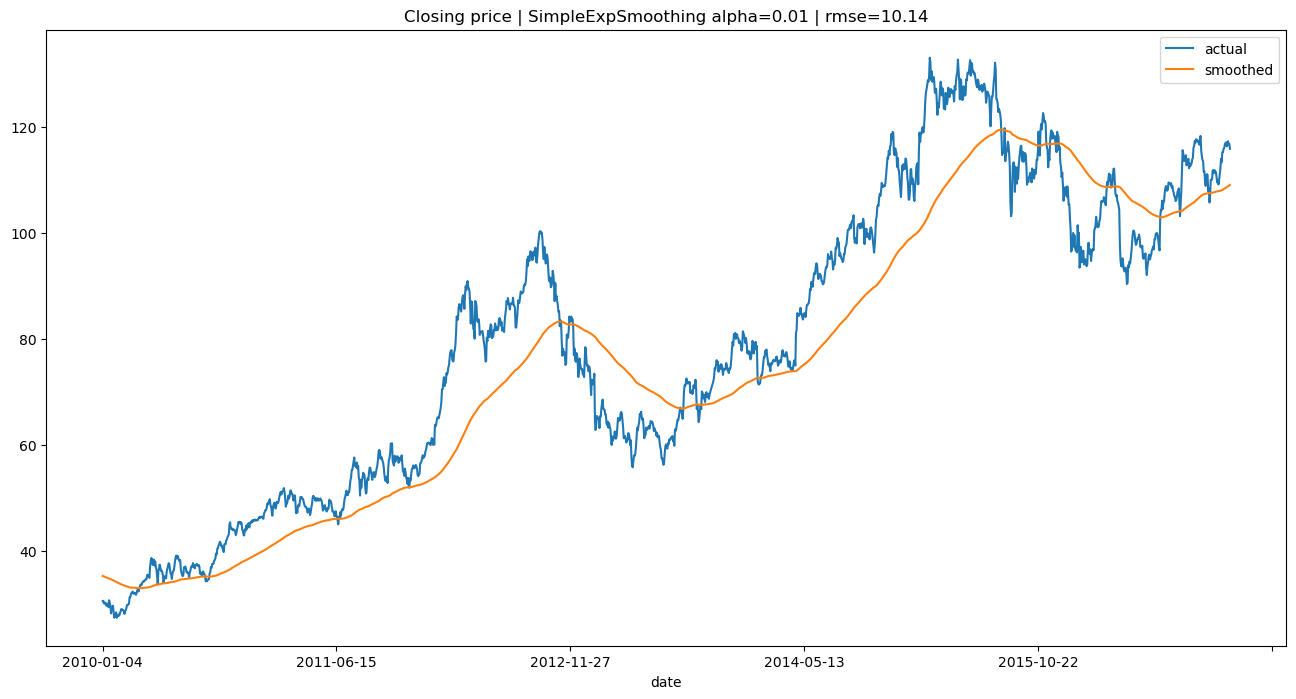

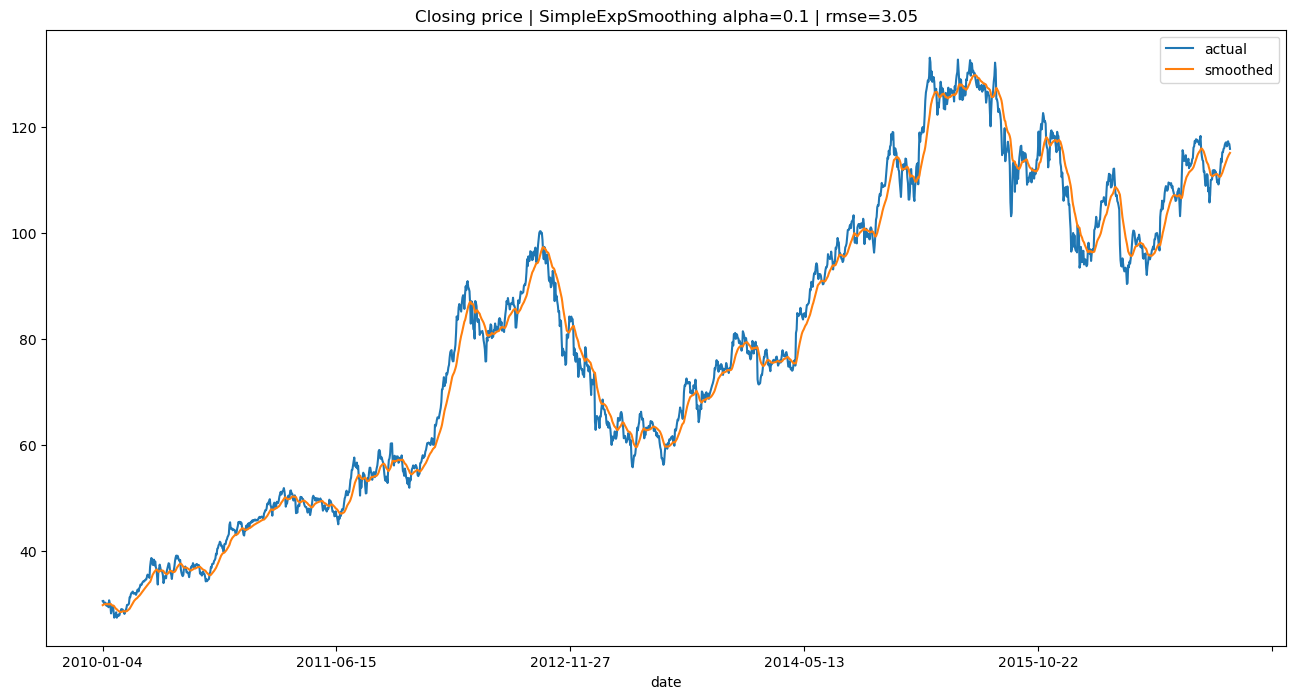

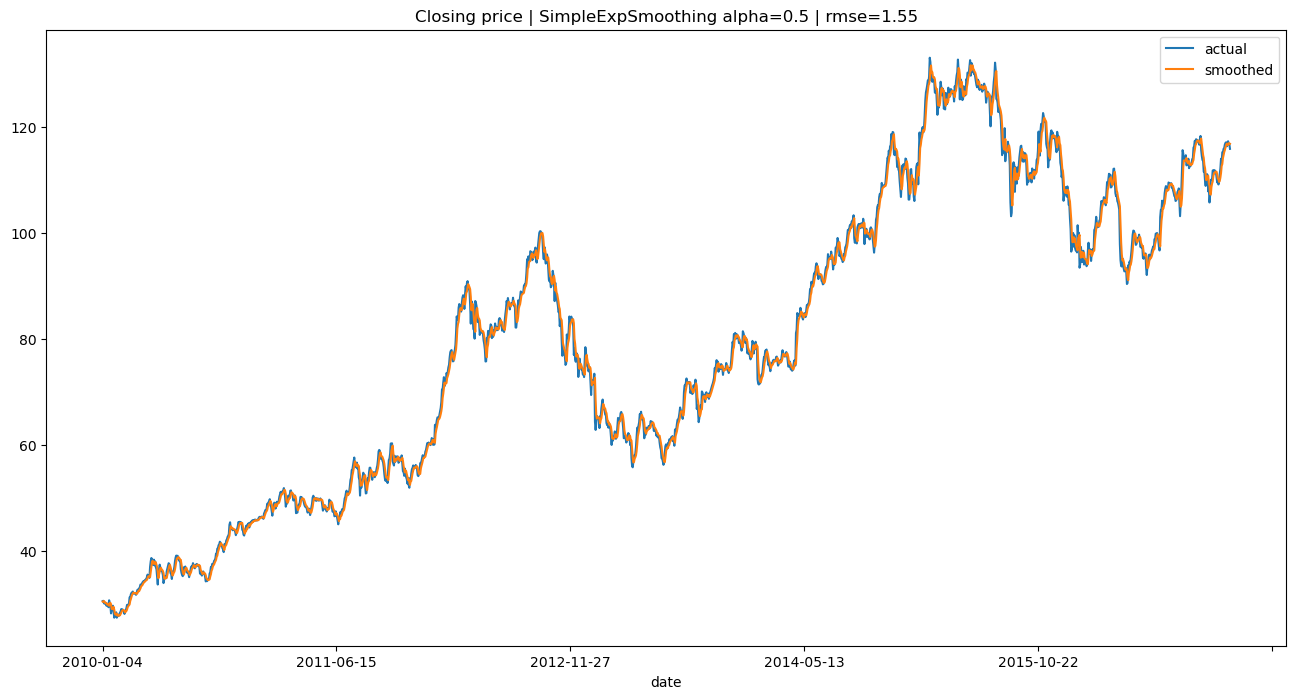

In [18]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
 
for alpha in [0.001, 0.01, 0.1, 0.5]:
    smoothed = SimpleExpSmoothing(
        X.close,
        initialization_method="estimated"
    ).fit(smoothing_level=alpha)

    plot([X.close, smoothed.fittedvalues],
         ["actual", "smoothed"],
         f"Closing price "
         f"| SimpleExpSmoothing alpha={alpha} "
         f"| rmse={(smoothed.sse/len(X.close))**0.5:.2f}")

Bigger the alpha, smaller the Root Mean Square Error (RMSE). Essentially, giving more weight to recent values.

Now let's see Holt Winter’s Exponential Smoothing (triple exponential smoothing).

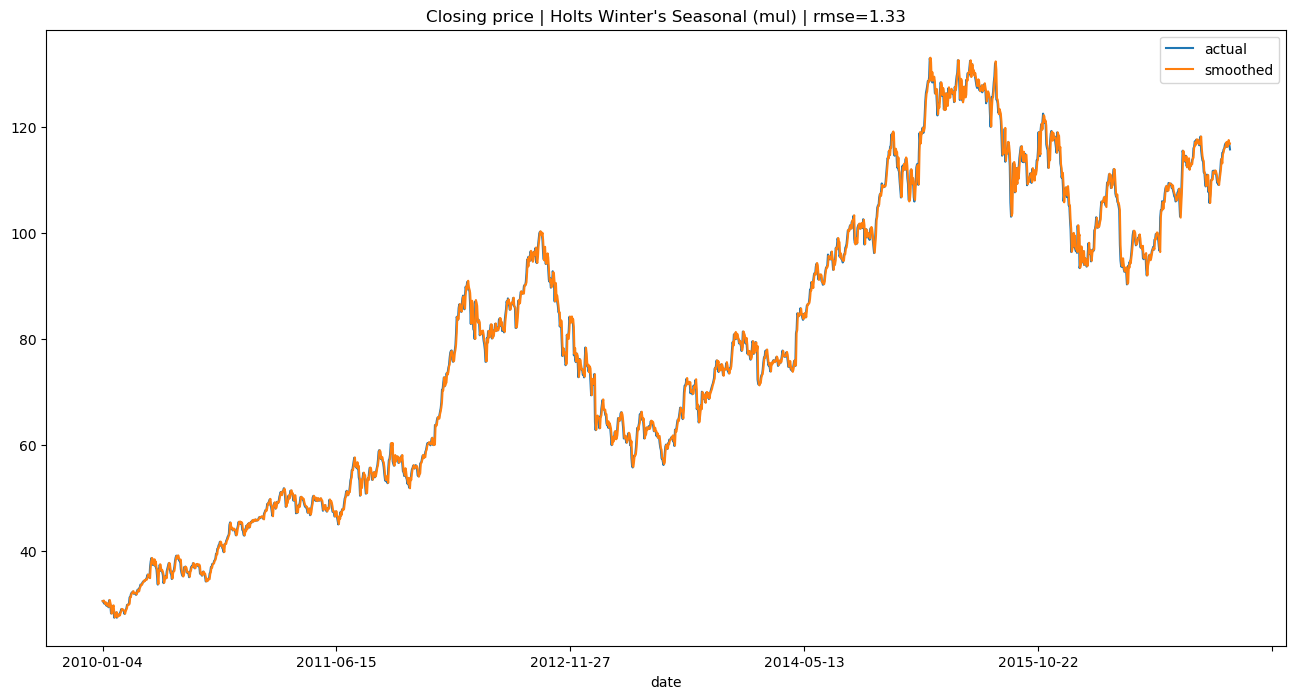

In [19]:
smoothed = ExponentialSmoothing(
    X.close,
    seasonal_periods=14,
    trend="add",
    seasonal="mul",
    use_boxcox=True,
    initialization_method="estimated",
).fit()

plot([X.close, smoothed.fittedvalues],
     ["actual", "smoothed"],
     f"Closing price "
     f"| Holts Winter's Seasonal (mul) "
     f"| rmse={(smoothed.sse/len(X.close))**0.5:.2f}")

It's a little better than simple exponential smoothing. Anyway, here's how prediction with one of these models looks like:

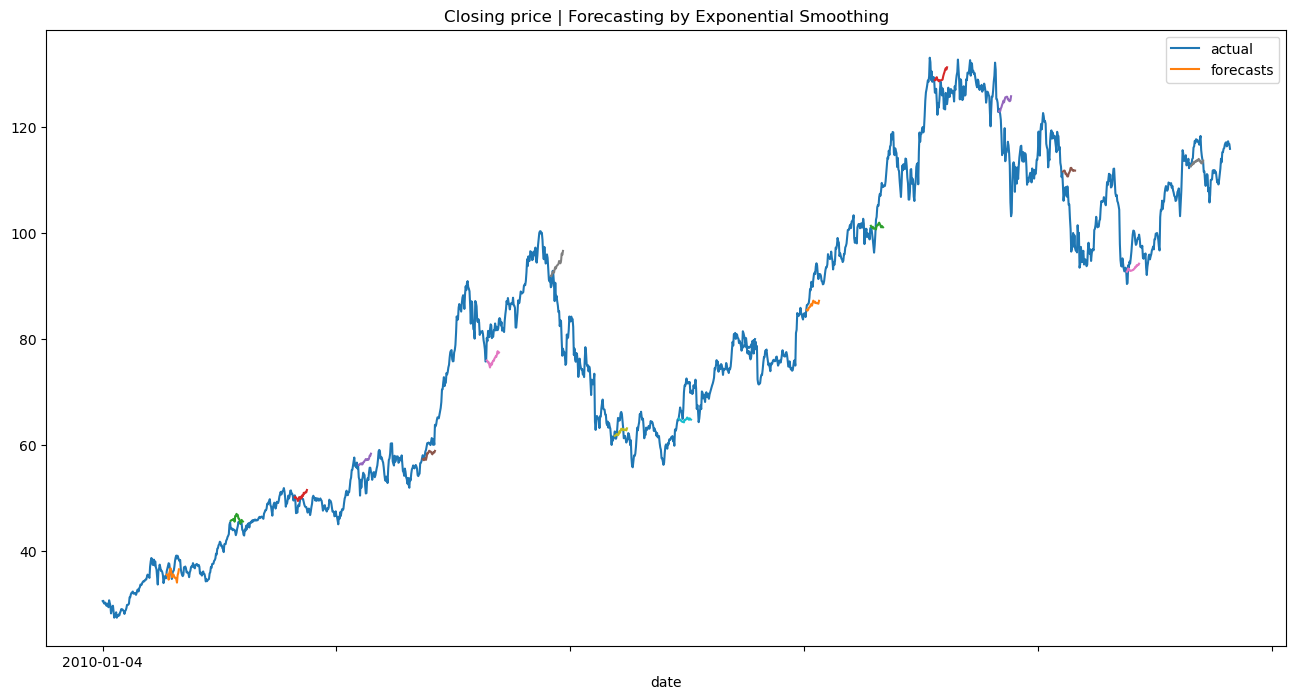

In [20]:
forecasts = []
for i in range(100, len(X), 100):
    model = ExponentialSmoothing(
        X.close[:i],
        seasonal_periods=30,
        trend="add",
        seasonal="mul",
        use_boxcox=True,
        initialization_method="estimated",
    ).fit() 

    forecast = model.forecast(20)
    forecasts.append(forecast)

plot([X.close, *forecasts],
     ["actual", "forecasts"],
     f"Closing price "
     f"| Forecasting by Exponential Smoothing")

Difficult to evaluate visually. But a general upward trend causes most of our forecasts to be upward bound.

Okay, let's do some forecasting with some real models.

## [Forecasting](https://en.wikipedia.org/wiki/Forecasting)

Let's start by writing some helper functions first.

There are many possible [metrics](https://en.wikipedia.org/wiki/Forecasting#Forecasting_accuracy) to choose from. I choose mean absolute percentage error and root mean squared error [just because](https://www.youtube.com/shorts/pg_bu5KF68s).

In [21]:
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_percentage_error
)

def score(y_true, y_pred, scoring="mse"):
    return {
        "mape": mean_absolute_percentage_error,
        "mse": mean_squared_error,
    }.get(scoring)(y_true, y_pred)

In [22]:
import numpy as np

def test_split(X, test_size=0.10):
    if isinstance(test_size, float):
        test_size = int(test_size * len(X))
    return np.split(X, [-test_size])

Of course, we want to split our dataset into train and test set before we start doing anything lest we desire [data leakage](https://en.wikipedia.org/wiki/Leakage_(machine_learning)).

In [23]:
X_train, X_test = test_split(X, 10)
X_train.shape, X_test.shape

((1752, 5), (10, 5))

A function to visualize our forecasts to see how well we are doing, beyond just numbers.

In [24]:
def plot_forecasts(y_train, y_test, y_fore, title=None, ax=None):
    if ax is None:
        ax = plt
    ax.plot(y_train)
    ax.plot(y_test)
    ax.plot(y_fore)
    if ax == plt:
        ax.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.title(title)
    else:
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.set_title(title)
    ax.legend(["train", "actual", "forecast"], loc="upper left")

Okay, let's start building our model. First up, ARIMA.

#### [ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average)

Autoregressive (AR) integrated (I) moving average (MA) model. We're already familiar with MA (rolling mean). AR is for when the variable is regressed on it's own lag. AR/MA models expect stationarity. Now, the I indicates that this is accounted for as well: the data is made stationary by the model (typically by differencing). Let's go.

In [25]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(X_train.close).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                 1752
Model:                          ARIMA   Log Likelihood               -8340.400
Date:                Fri, 08 Dec 2023   AIC                          16684.800
Time:                        21:14:13   BIC                          16695.737
Sample:                             0   HQIC                         16688.843
                               - 1752                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         79.1904      0.675    117.240      0.000      77.866      80.514
sigma2       799.0141     40.723     19.621      0.000     719.199     878.829
===================================================================================
Ljung-Box (L1) (Q):                1746.41   Jarque-Bera (JB):                91.69
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                             0.01
Prob(H) (two-sided):                  0.76   Kurtosis:                         1.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We have some numbers and information which we'll pretend to understand. Now, forecasting:

In [26]:
forecast = model.forecast(10)
forecast, X_test.close[:10]

(1752    79.190364
 1753    79.190364
 1754    79.190364
 1755    79.190364
 1756    79.190364
 1757    79.190364
 1758    79.190364
 1759    79.190364
 1760    79.190364
 1761    79.190364
 Name: predicted_mean, dtype: float64,
 date
 2016-12-16    115.970001
 2016-12-19    116.639999
 2016-12-20    116.949997
 2016-12-21    117.059998
 2016-12-22    116.290001
 2016-12-23    116.519997
 2016-12-27    117.260002
 2016-12-28    116.760002
 2016-12-29    116.730003
 2016-12-30    115.820000
 Name: close, dtype: float64)

Doesn't seem right... Yes, of course, we forgot the differencing for stationarity. While I said it's accounted for, it needs to be explicitly made clear that we want the model to take care of it.

[ARIMA](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html#statsmodels.tsa.arima.model.ARIMA) has `order` parameter: (p, d, q). AR(p), MA(q) and d for degree of differencing. Let's go with d=1 for now.

In [27]:
model = ARIMA(X_train.close, order=(0, 1, 0)).fit()
forecast = model.forecast(10)

forecast, X_test.close[:10]

(1752    115.82
 1753    115.82
 1754    115.82
 1755    115.82
 1756    115.82
 1757    115.82
 1758    115.82
 1759    115.82
 1760    115.82
 1761    115.82
 Name: predicted_mean, dtype: float64,
 date
 2016-12-16    115.970001
 2016-12-19    116.639999
 2016-12-20    116.949997
 2016-12-21    117.059998
 2016-12-22    116.290001
 2016-12-23    116.519997
 2016-12-27    117.260002
 2016-12-28    116.760002
 2016-12-29    116.730003
 2016-12-30    115.820000
 Name: close, dtype: float64)

Much better. Now, to plot:

0.8005598640042088

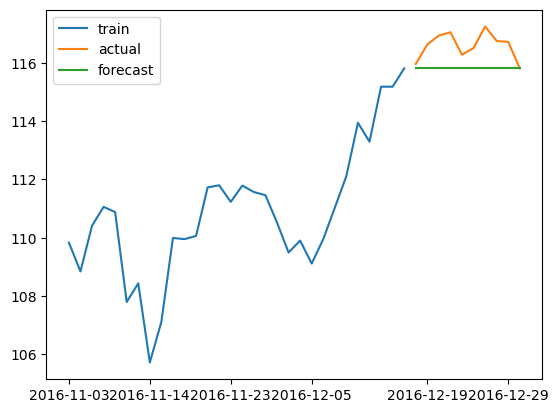

In [28]:
forecast.index = X_test.index[:10]
plot_forecasts(X_train.close[len(X_train) - 30:], X_test.close[:30], forecast)
score(X_test.close[:10], forecast)

The forecast seems to be a straight line. The scores don't make much sense on their own right now, but we'll come back to that later.

Let's do some [cross validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)).

ARIMA takes X as class param instead of fit param. So we write a wrapper class to standardize the API

In [29]:
class Arima:
    def __init__(self, order=None):
        self.order = order

    def fit(self, X):
        self.model = ARIMA(X, order=self.order).fit()
        return self

    def forecast(self, n=1):
        return self.model.forecast(n)

    def append(self, next):
        self.model = self.model.append([next])

In cross validation, we'll fit and forecast the model on multiple folds. This is to ensure, there's no luck in our choice of test set. Also let's us know how well the model does on independent sets.

`sklearn` has a [cross_validate](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) function. But here, I write my own as 1. the API for ARIMA is not compatible and 2. I want to plot graphs for each fold. It's simpler to just write the function here than to write a proper wrapper for ARIMA.

To split the data in each iteration, we use [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html). Why not KFold? Time goes forward. We want to make sure that all our test data points are _after_ our train data points so that we don't train our model on future data.

We consider 2 types of models: live and forecasting model. Live model, unlike forecasting model, predicts next step, then uses the real observed value to update the model for upcoming predictions. Forecasting can be helpful when you want to know how a stock will perform in the next week, month, quarter or year.

In [30]:
# 1w = 5 business days
forecast_lengths = [5, 20, 60, 120]

def score_forecasting_model(model, y_test, scoring):
    y_forecasts = model.forecast(max(forecast_lengths))

    scores = {}
    for forecast_length in forecast_lengths:
        if forecast_length > len(y_test):
            break

        scores[forecast_length] = (
            score(
                y_test[:forecast_length],
                y_forecasts[:forecast_length],
                scoring
            ),
            y_forecasts[:forecast_length].values
        )
    return scores

In [31]:
def score_live_model(model, y_test, scoring):
    def predict_and_append(model, next=None):
        y_pred = model.forecast(1)
        model.append(next or y_pred)
        return y_pred

    y_pred = np.array([predict_and_append(model, y_true) for y_true in y_test])
    return score(y_test, y_pred, scoring), y_pred

In [32]:
def score_model(model, y_test, scoring="mse", model_type="live"):
    if model_type == "live":
        return score_live_model(model, y_test, scoring)
    return score_forecasting_model(model, y_test, scoring)

In [33]:
from sklearn.model_selection import TimeSeriesSplit

index_close = X.columns.get_loc("close")

def cross_validate(
    model,
    X,
    scoring="mse",
    model_type="live",
    plot_forecast=False,
):
    scores = []

    if plot_forecast:
        fig, axes = plt.subplots(
            nrows=5,
            ncols=1,
            constrained_layout=True,
            figsize=(8, 12)
        )        

    tscv = TimeSeriesSplit(n_splits=5)
    for i, (train_idx, test_idx) in enumerate(tscv.split(X)):
        y_train, y_test = X.iloc[train_idx, index_close], X.iloc[test_idx, index_close]

        model.fit(y_train)

        results = score_model(model, y_test, scoring, model_type)
        if model_type == "live":
            score, y_pred = results
        else:
            score = [results[forecast_length][0] for forecast_length in forecast_lengths]
            y_pred = results[max(forecast_lengths)][1]

        scores.append(score)
        
        if plot_forecast and len(y_pred) >= 5:
            plot_forecasts(
                y_train,
                y_test,
                pd.DataFrame(y_pred, index=y_test.index[:len(y_pred)]),
                f"split {i}",
                axes[i%5],
            ) 

    return scores

2.079699603161928

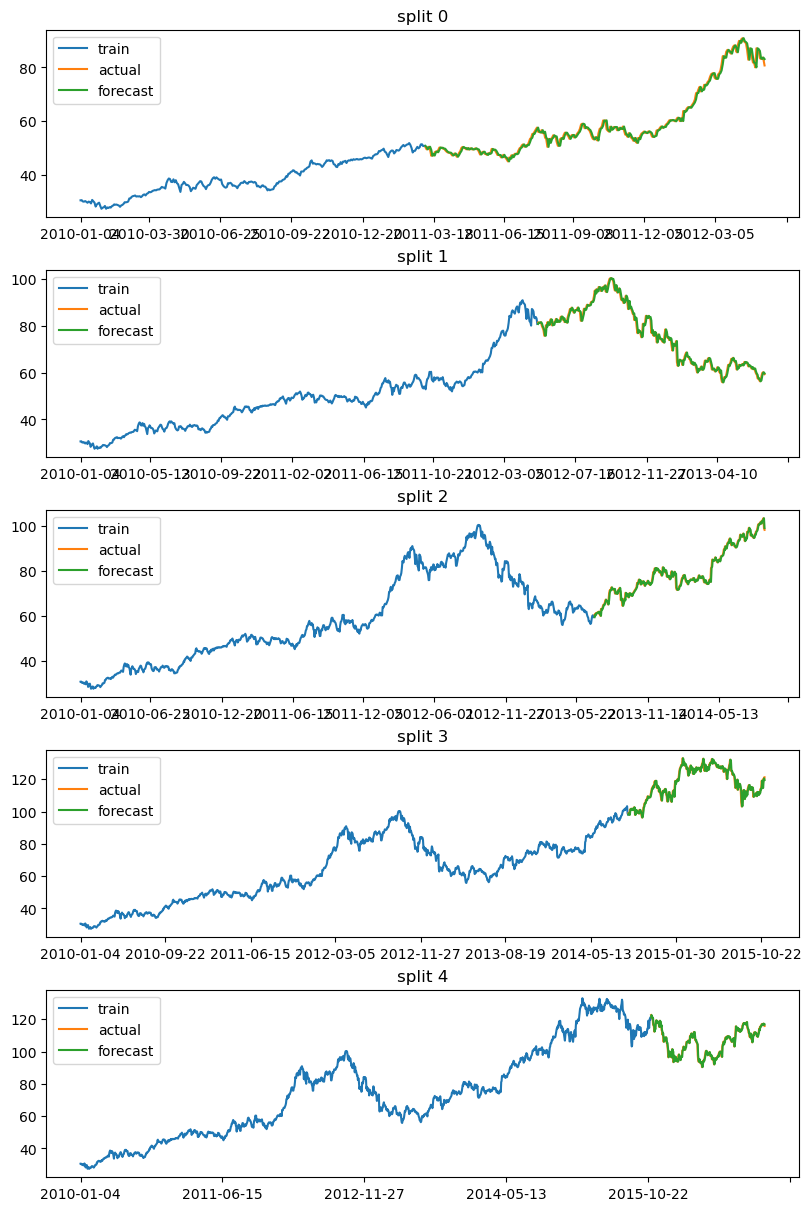

In [34]:
np.mean(cross_validate(Arima(order=(0, 1, 0)), X, plot_forecast=True))

array([  1.58649097,   9.36413868,  78.3427024 , 158.86177556])

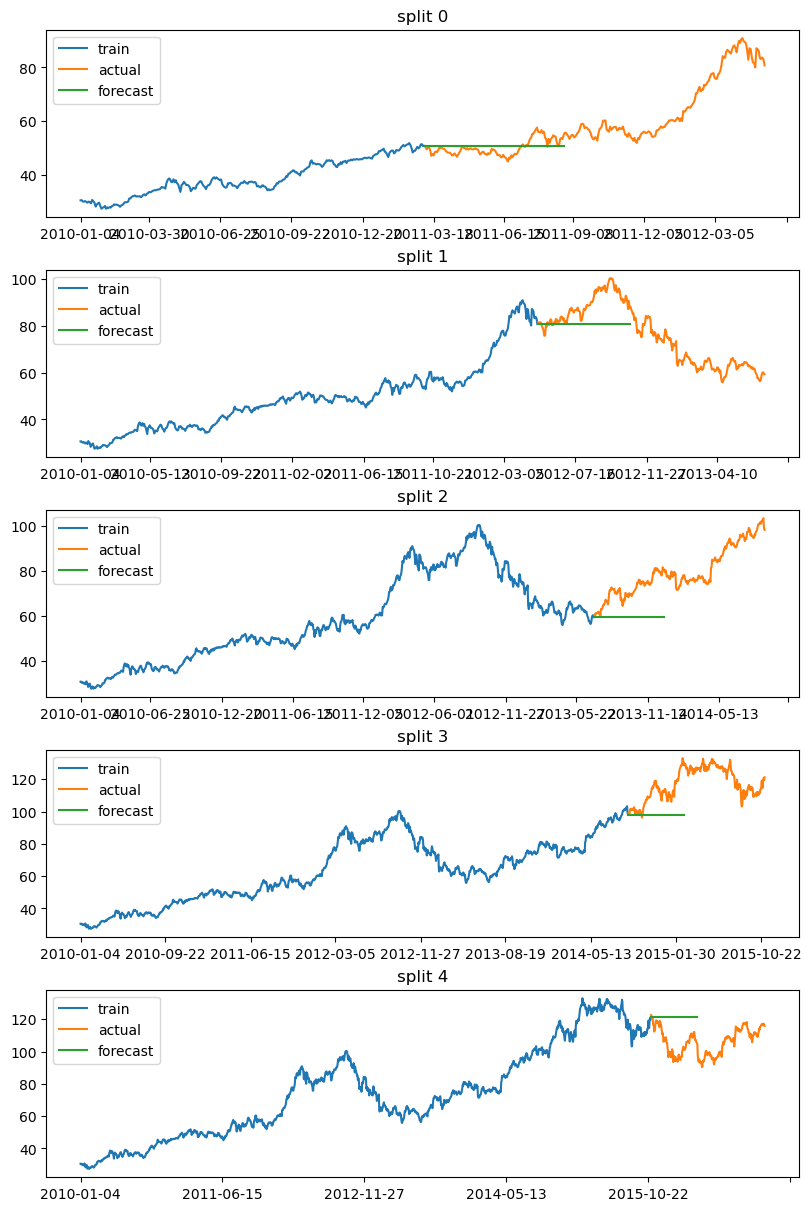

In [35]:
np.mean(cross_validate(Arima(order=(0, 1, 0)), X, model_type="forecasting", plot_forecast=True), axis=0)

The forecast is pretty much a straight line... But is it good? I don't know. We need a baseline.

#### Baseline

Let's do a simple weighted mean of the last n values. The weights are simply the index. This is similar to exponential smoothing I suppose, but slightly different. This model should suffice.

In [36]:
class WeightedAverage:
    def __init__(self, last_n=5):
        self.last_n = last_n

    def fit(self, X):
        self.history = X[-self.last_n:].tolist()
        return self

    def _forecast_one(self):
        # Weights are indices
        weighted_sum = sum(i * x for i, x in enumerate(self.history))
        sum_of_weights = self.last_n * (self.last_n - 1) / 2
        return weighted_sum / sum_of_weights

    def forecast(self, n=1):
        if n == 1:
            return self._forecast_one()

        def predict_and_append():
            next = self._forecast_one()
            self.append(next)
            return next

        return pd.Series([predict_and_append() for i in range(n)])

    def append(self, next):
        self.history = self.history[1:] + [next]

But what should be the value of `last_n`? Let's do [hyper parameter tuning](https://en.wikipedia.org/wiki/Hyperparameter_optimization). Given a grid of parameters, it cross validates all possible combinations to find the best model for us (yay). Again, `sklearn` offers [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) but the same story...

In [37]:
from itertools import product

def hyper_parameter_tuning(
    estimator_class,
    grid,
    X,
    model_type="live",
):
    args = list(product(*grid.values()))

    validation_scores = {}
    for arg in args:
        validation_scores[arg] = cross_validate(
            estimator_class(*arg),
            X,
            model_type=model_type,
        )

    if model_type == "live":
        best_arg = min(
            validation_scores,
            key=lambda x: np.mean(validation_scores[x])
        )
        return (best_arg, validation_scores[best_arg])

    best_args = {}
    for i, forecast_length in enumerate(forecast_lengths):
        best_arg = min(
            validation_scores,
            key=lambda x: np.mean(validation_scores[x], axis=0)[1]
        )
        scores = [score[i] for score in validation_scores[best_arg]]
        best_args[forecast_length] = (best_arg, scores)
    return best_args

In [38]:
grid = {
    "last_n": range(2, 10),
}

hyper_parameter_tuning(WeightedAverage, grid, X)

((2,),
 [1.2964443332222118,
  2.039525838678627,
  1.2413902083208617,
  3.472815614143833,
  2.3483220214441083])

In [39]:
np.mean(cross_validate(WeightedAverage(last_n=2), X))

2.079699603161928

So apparently, `last_n=2` gives the best results which is literally just yesterday's closing price! How about forecasting?

In [40]:
grid = {
    "last_n": range(2, 100)
}

hyper_parameter_tuning(
    WeightedAverage,
    grid,
    X,
    model_type="forecasting",
)

{5: ((7,),
  [1.0880190284426376,
   1.5966650494237264,
   1.6119653038797577,
   2.806688598872053,
   3.385485799770315]),
 20: ((7,),
  [4.065134685271824,
   8.225956049333139,
   13.325894311706378,
   2.1805984294231733,
   11.128392060841977]),
 60: ((7,),
  [5.15059299820272,
   8.043275371216312,
   70.50194118562186,
   66.47267831258952,
   184.88052226749173]),
 120: ((7,),
  [8.813233025840127,
   72.20365866612379,
   169.2947493102884,
   182.2808659355666,
   256.81687231725687])}

We have `last_n=7`. Okay, now we have a baseline. The scores are similar. So, we still have some tuning to do for ARIMA.

In [41]:
np.mean(cross_validate(WeightedAverage(last_n=7), X, model_type="forecasting"), axis=0)

array([  2.09776476,   7.78519511,  67.00980203, 137.88187585])

#### Tuning ARIMA

We do a grid search again.

In [42]:
grid = {
    "order": list(product(*[
        [0, 1, 2], #p
        [1, 2], #d
        [0, 1, 2] #q
    ])),
}

hyper_parameter_tuning(Arima, grid, X)

(((0, 1, 0),),
 [1.2964443332222118,
  2.039525838678627,
  1.2413902083208617,
  3.472815614143833,
  2.3483220214441074])

In [43]:
np.mean(cross_validate(Arima(order=(0, 1, 0)), X))

2.079699603161928

(0, 1, 0) is random walk!

In [44]:
grid = {
    "order": list(product(*[
        [0, 1, 2], #p
        [1], #d
        [0, 1, 2] #q
    ])),
}

hyper_parameter_tuning(
    Arima,
    grid,
    X,
    model_type="forecasting",
)

{5: (((2, 1, 2),),
  [0.8841135882546929,
   0.12744988093197632,
   2.2123417464641064,
   3.89229088129989,
   0.5993400374196468]),
 20: (((2, 1, 2),),
  [3.7304186908812573,
   3.9668651388887683,
   14.736461149033136,
   6.902806484877701,
   16.257540480638465]),
 60: (((2, 1, 2),),
  [4.758848550437134,
   11.475789207424953,
   73.92896220564472,
   87.24904200592323,
   208.0793284919017]),
 120: (((2, 1, 2),),
  [8.657034126018209,
   91.21321420661185,
   174.64646004888127,
   221.9230681486307,
   287.22229970918335])}

In [45]:
np.mean(cross_validate(Arima(order=(2, 1, 2)), X, model_type="forecasting"), axis=0)

array([  1.54310723,   9.11881839,  77.09839409, 156.73241525])

Btw, `pmdarima`'s [auto_arima](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html) chooses `SARIMAX(2, 1, 2)` for this data. We could also determine the best `order` [by analysis](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/) (done before), but this is easier and does not require domain knowledge. We do see that (2, 1, 2) and higher agrees with the autocorrelation and partial autocorrelation graph way up above.

In [46]:
from pmdarima.arima import auto_arima

auto_arima(X.close, trace=True, n_jobs=-1)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6025.462, Time=3.01 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6028.124, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6029.471, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6029.437, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6028.427, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6031.468, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6033.360, Time=0.72 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=6034.508, Time=1.30 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=6034.511, Time=1.57 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6031.172, Time=1.01 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6032.708, Time=1.78 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=6033.304, Time=0.57 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=3.44 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=6025.756, Time=0.69 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] i

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True)

### [RNN](https://en.wikipedia.org/wiki/Recurrent_neural_network)

We'll be building [Long short-term memory](https://en.wikipedia.org/wiki/Long_short-term_memory) model, a recurrent neural network. Start by preparing the input for the network. LSTM expects set of training _sequences_. So each row of the training set will be X\[i\] = \[t1, t2, t3, ... tn\], y\[i] = tn+1. Of course, y\[i] can be a list if we want to do multi-step predictions. For now, we keep `out_sequence_length=1`.

In [47]:
def generate_sequences(X, in_sequence_length=30, out_sequence_length=1):
    sequences = np.array([
        X[i - in_sequence_length:i]
        for i in range(in_sequence_length, len(X) - out_sequence_length + 1)
    ])

    targets = np.array([
        X.iloc[i: i + out_sequence_length, index_close]
        for i in range(in_sequence_length, len(X) - out_sequence_length + 1)
    ])

    assert len(targets) == len(sequences)

    if out_sequence_length == 1:
        targets = targets.reshape(-1,)

    return sequences, targets

In [48]:
sequences, targets = generate_sequences(X)
sequences.shape, targets.shape

((1732, 30, 5), (1732,))

Let's use keras' [rnn api](https://keras.io/guides/working_with_rnns/) and [lstm layer](https://keras.io/api/layers/recurrent_layers/lstm/) to build the network. We shall have 2 LSTM layers and 2 Dense layers. We could with optimize for either MAPE or (R)MSE.

In [49]:
import keras

def build_model(units, input_shape, out_sequence_length=1, loss="mean_squared_error"):
    model = keras.Sequential([
        keras.layers.LSTM(units,
                          return_sequences=True,
                          input_shape=input_shape),
        keras.layers.LSTM(units,
                          input_shape=input_shape),
        keras.layers.Dense(units),
        keras.layers.Dense(out_sequence_length),
    ])

    model.compile(loss=loss, optimizer="adam")
    return model

2023-12-08 21:22:32.483198: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-08 21:22:32.507333: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [50]:
build_model(64, (30, 5)).summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            17920     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 55169 (215.50 KB)
Trainable params: 55169 (215.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


I tried not to write another `cross_validate` fn and instead use the earlier one, but couldn't. I use `StandardScaler`. I tried `MinMaxScaler` as well~, but the former performed better.~

In [51]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def cross_validate_lstm(
    X,
    in_sequence_length=30,
    out_sequence_length=1,
    plot_forecast=False
):
    scores = []

    if plot_forecast:
        fig, axes = plt.subplots(
            nrows=5,
            ncols=1,
            constrained_layout=True,
            figsize=(8, 12)
        )        

    # Noticed LSTM does terribly with very little train data
    tscv = TimeSeriesSplit(n_splits=5, test_size=120)
    for i, (train_idx, val_idx) in enumerate(tscv.split(X)):
        # Scale before splitting into sequences
        # Fit on train set only! Transform entire X
        mean = np.mean(X.iloc[train_idx], axis=0)
        std = np.std(X.iloc[train_idx], axis=0)
        X_scaled = (X - mean)/std

        sequences, targets = generate_sequences(
            X_scaled,
            in_sequence_length,
            out_sequence_length
        )

        #train_idx = train_idx[train_idx < len(targets)]
        X_train, y_train = sequences[train_idx], targets[train_idx]

        val_idx = val_idx[val_idx < len(targets)]
        X_val, y_val = sequences[val_idx], targets[val_idx]

        # For sequence[i], you are predicting y[i + in_sequence_length]
        y_true = X.iloc[val_idx + in_sequence_length, index_close]

        num_features = X_train.shape[-1]
        model = build_model(
            units=64,
            input_shape=(in_sequence_length, num_features),
            out_sequence_length=out_sequence_length,
        )

        model.fit(X_train, y_train, epochs=20, verbose=0)
        y_pred = model.predict(X_val)

        # invert the transform
        y_pred *= std[index_close]
        y_pred += mean[index_close]

        scores.append(score(y_true, y_pred))

        if plot_forecast:
            plot_forecasts(
                X.iloc[train_idx, index_close],
                y_true,
                pd.DataFrame(y_pred, index=y_true.index),
                f"split {i}",
                axes[i%5],
            )

    return scores

We use X here, please don't kill me. It doesn't matter yet.

4/4 [==============================] - 1s 4ms/step


[32.269679483513606,
 6.164242249309359,
 5.89092813790276,
 4.522843209884973,
 4.010028104277875]

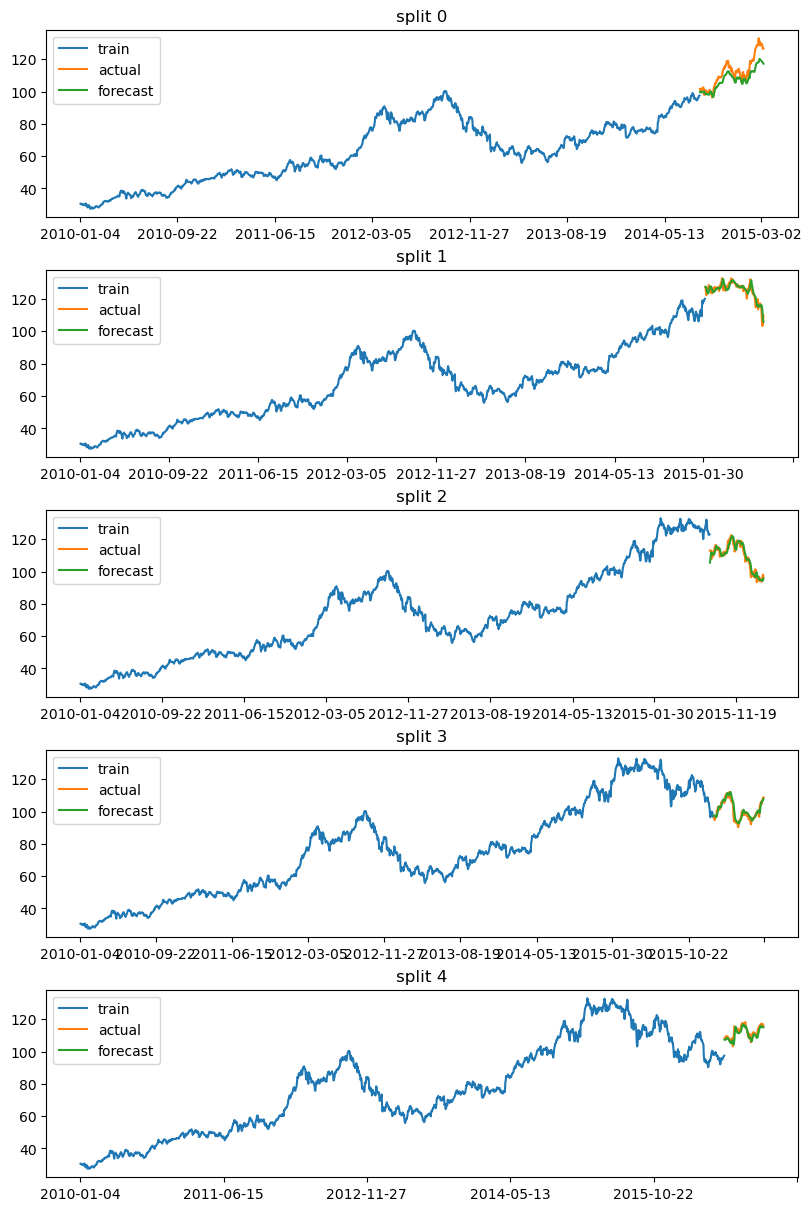

In [52]:
cross_validate_lstm(X, in_sequence_length=20, plot_forecast=True)

### Tuning LSTM

God bless [keras_tuner](https://keras.io/keras_tuner/)!

In [53]:
import keras_tuner
import random

def tuning_lstm(X, in_sequence_length=20, loss='mean_squared_error'):
    def build_model(hp):
        model = keras.Sequential([
            keras.layers.LSTM(
                hp.Choice('units', [8, 16, 32, 64, 128]),
                return_sequences=True,
                input_shape=input_shape
            ),
            keras.layers.LSTM(
                hp.Choice('units', [8, 16, 32, 64, 128]),
                input_shape=input_shape
            ),
            keras.layers.Dense(
                hp.Choice('units', [8, 16, 32, 64, 128])
            ),
            keras.layers.Dense(out_sequence_length),
        ])
    
        model.compile(
            loss=loss,
            optimizer="adam",
            metrics=[keras.metrics.MeanSquaredError()],
        )
        return model

    out_sequence_length = 1
    num_features = X.shape[-1]
    input_shape = (in_sequence_length, num_features)

    # We can't tune on test set!
    test_size = 120
    X_nontest, X_test = X[:-test_size], X[-test_size:]

    # Val split
    val_size = random.randint(50, 100)
    train_size = len(X) - test_size - val_size

    train_idx = np.arange(train_size)
    val_idx = np.arange(train_size, train_size + val_size)

    # Scale
    mean = np.mean(X_nontest.iloc[train_idx], axis=0)
    std = np.std(X_nontest.iloc[train_idx], axis=0)
    X_scaled = (X_nontest - mean)/std

    sequences, targets = generate_sequences(
        X_scaled,
        in_sequence_length,
        out_sequence_length
    )

    X_train, y_train = sequences[train_idx], targets[train_idx]

    val_idx = val_idx[val_idx < len(targets)]
    X_val, y_val = sequences[val_idx], targets[val_idx]

    tuner = keras_tuner.RandomSearch(
        build_model,
        objective=keras_tuner.Objective("val_mean_squared_error",
                                        direction="min"),
        max_trials=5,
        overwrite=True,
    )

    tuner.search(
        X_train,
        y_train,
        epochs=37,
        validation_data=(X_val, y_val),
    )
    return tuner.get_best_models()[0]

In [54]:
model = tuning_lstm(X, in_sequence_length=20, loss='mean_squared_error')
print(model.summary())

Trial 5 Complete [00h 00m 28s]
val_mean_squared_error: 0.002622863743454218

Best val_mean_squared_error So Far: 0.002536173677071929
Total elapsed time: 00h 02m 19s
INFO:tensorflow:Oracle triggered exit
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 128)           68608     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 216833 (847.00 KB)
Trainable params: 216833 (847.00 KB)
Non-trainable params: 0 (0.00 Byte)
__________

For MSE, `unit=128`. Okay, let's try the best models we have.

In [55]:
X = prices[prices.symbol == stock_symbol].drop(["symbol"], axis=1)
test_size = random.randint(60, 120)

In [56]:
X_train, X_test = test_split(X.close, test_size=test_size)

model_base = WeightedAverage(last_n=2).fit(X_train)
print(f"Baseline: {score_live_model(model_base, X_test, scoring='mse')[0]}")

model_arima = Arima(order=(0, 1, 0)).fit(X_train)
print(f"Arima: {score_live_model(model_base, X_test, scoring='mse')[0]}")

Baseline: 1.209328171654673
Arima: 1.3199076083713144


In [57]:
def test_lstm(model, in_sequence_length, X_train, X_test):
    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
    X_train, y_train = generate_sequences(X_train, in_sequence_length, out_sequence_length)

    model.fit(X_train, y_train, epochs=37, verbose=0)

    y_true = X_test.iloc[in_sequence_length:, index_close]
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
    X_test, y_test = generate_sequences(X_test, in_sequence_length, out_sequence_length)

    y_pred = model.predict(X_test)
    y_pred *= scaler.scale_[index_close]
    y_pred += scaler.mean_[index_close]

    return score(y_true, y_pred)

out_sequence_length = 1
for in_sequence_length in [2, 5, 20, 30]:
    X_train, X_test = X[:-test_size], X[-test_size-in_sequence_length-out_sequence_length:]
    
    model = build_model(
        units=128,
        input_shape=(in_sequence_length, X_train.shape[-1]),
        loss="mean_squared_error",
    ) 
    
    print(f"LSTM (in_sequence_length={in_sequence_length}): "
          f"{test_lstm(model, in_sequence_length, X_train.copy(), X_test.copy())}")

3/3 [==============================] - 0s 2ms/step
LSTM (in_sequence_length=2): 1.1708088899583955
3/3 [==============================] - 0s 2ms/step
LSTM (in_sequence_length=5): 2.5614478039422353
3/3 [==============================] - 1s 5ms/step
LSTM (in_sequence_length=20): 1.2163211760680956
3/3 [==============================] - 1s 6ms/step
LSTM (in_sequence_length=30): 6.318674496475574


The performance is about the same as baseline algorithm of just picking the last price. So, our LSTM is basically just picking yesterday's price. Is it wrong? Not really. Is it unexpected? Also [no](https://en.wikipedia.org/wiki/Smoothing#Algorithms). It is [known](https://archive.is/LN6ZP) that LSTM with just price information is not a good model.

### 

## Conclusion

You've reached the end of this notebook. This is my first time dealing with time series. So I had to go through a lot of Wikipedia pages, guides and blog posts to complete this project, and I learned a lot of new and exciting stuff.

Our models did not perform very well. (Of course, I'm keeping the models that _did_ perform well to myself :p) This is understandable as we only used the historical price data for prediction. Forces that move the market are much more [complex](https://www.investopedia.com/articles/basics/04/100804.asp).
The baseline model is simply using yesterday's price as the prediction. It performs better than ARIMA; the best ARIMA is simply random walk. LSTM does better sometimes, but there's a lot of variance. I also suspect the pre/post processing adds to the error in LSTM model

**Extra**

* I tried VARMAX: Vector AR MA with eXogenous regressors model, but it wasn't as good. My guess?
  * I had to make it stationary by differencing and then inverting to evaluate; error propogation.
  * It tries to optimize for all output variables, so it likely had to balance out the errors.

**Future**

* Reward correct direction (up/down) prediction.* Use financial data made available through the other csv files (fundamentals.csv and securities.csv) in this dataset.
* Other kinds of models like GRUs and CNNs. There is also the model Prophet by Facebook.
